# Film Script Analyzer

## Data Visualization

## Plots

In [113]:
import pandas as pd

df = pd.read_csv('data/dfreps0.csv',index_col=0)

All the steps taken up to this point were to gather, clean, filter and prepare data for visualization and analysis. With the dataset ready it is time to proceed, start by showing a correlation matrix to how the features are related with each other, since the correlation matrix is 44 by 44, only selected fragments are shown.

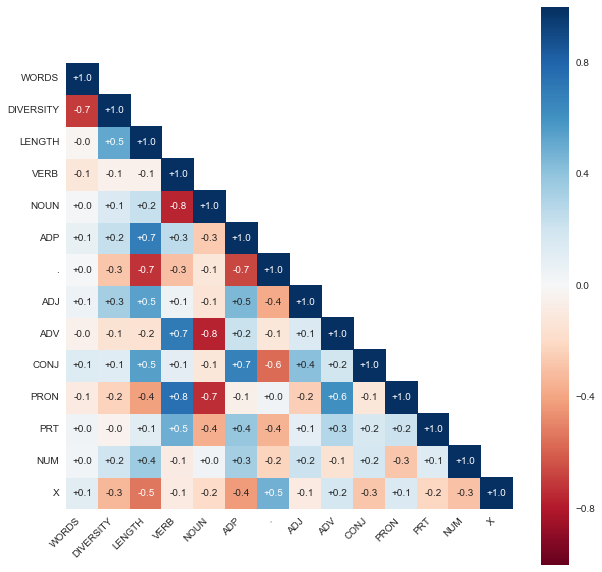

In [2]:
import seaborn           as sns
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib        as mpl
%matplotlib inline

mpl.rc("figure", figsize=(10,10))
corr = df[df.columns[30:44]].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, 1)] = True

with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, square=True, annot=True, cmap='RdBu', fmt='+.1f')
    plt.xticks(rotation=45, ha='right');

Some interesting although logical findins from the correlation matrix, many interactions among the componentes of the sentences like:
- Words is correlated negatively with Diversity, the more words form the script the higher the chance of repetition, thus a decreased diversity.
- Lenght and Diversity are positevely correlated, perhaps a bigger vocabulary has longer words.
- Adverbs and verbs go usually together.

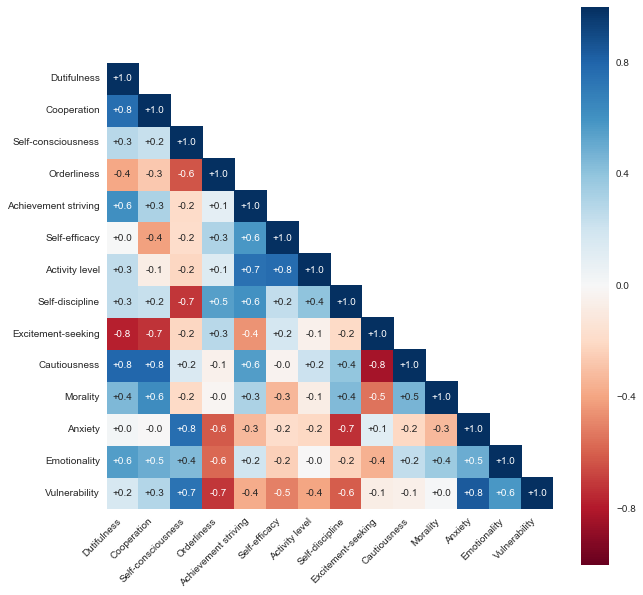

In [8]:
mpl.rc("figure", figsize=(10,10))
corr = df[df.columns[:14]].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, 1)] = True

with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, square=True, annot=True, cmap='RdBu', fmt='+.1f')
    plt.xticks(rotation=45, ha='right');

- Excitement-seeking heavily negatively correlated with Dutifulness and Cautiousness which makes sense.
- Activity level heavily positively correlated with Self-efficacy and Achievement striving, again it is expected.
- It is intersing to find Anxiety inversely correlated to Self-Discipline (and Orderliness), guess lack of control producess anxiety.

Two of the targets to predict from the raw text are the Genre and the Rating, will use Feature Selection for  Classification / Regression and will extract the most important features for classification, this limitation is used for visualization purposes only.

In [31]:
from sklearn.feature_selection import SelectFromModel, SelectKBest, mutual_info_classif, mutual_info_regression
import numpy                   as np

nasc      = ~df['Genre1'].isnull()
train_c   = df[df.columns[:44]].ix[nasc]
target_c  = df['Genre1'].ix[nasc]
clf_c     = SelectKBest(mutual_info_classif,k=12)
clf_c.fit(train_c,target_c)
c_c       = list(train_c.columns[clf_c.get_support(True)])

#nasr     = ~df['imdbRating'].isnull()
#train_r  = df[df.columns[:44]].ix[nasr]
#target_r = df['imdbRating'].ix[nasr]
#clf_r    = SelectKBest(mutual_info_regression,k=12)
#clf_r.fit(train_r,target_r)
#c_r      = list(train_r.columns[clf_r.get_support(True)])

#feats    = list(set(c_r).intersection(set(c_c)))
#feats

Perform Principal Component Analysis to check the influence of the features that account for the greatest variation.

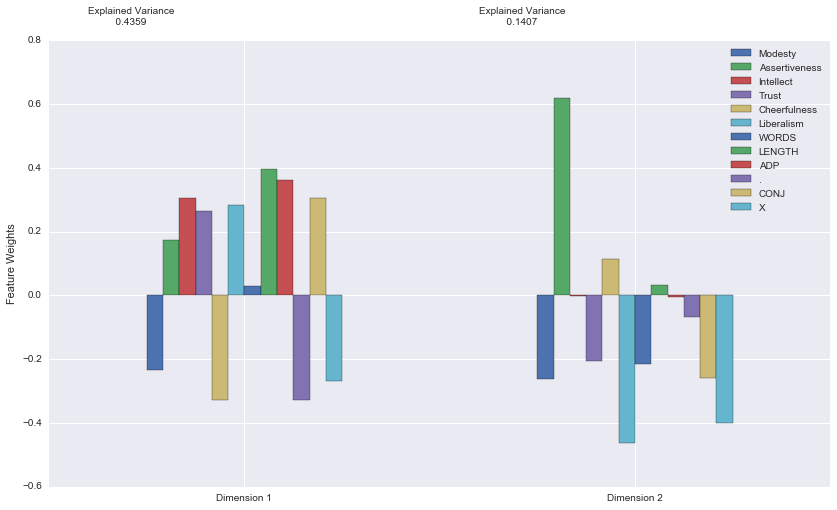

In [30]:
from sklearn.decomposition import PCA
import rs

n = 2
mpl.rc("figure",figsize=(10,10))
pca     = PCA(n_components=n,whiten=True)
pca.fit(df[c_c])

pca_results = rs.pca_results(df[c_c],pca)

Check the genres with the highest counts.

In [77]:
n = 9
target_names = df['Genre1'].value_counts()[:n]
target_names

Comedy         2418
Drama          1959
Action         1563
Crime           652
Horror          582
Documentary     570
Adventure       495
Animation       402
Biography       387
Name: Genre1, dtype: int64

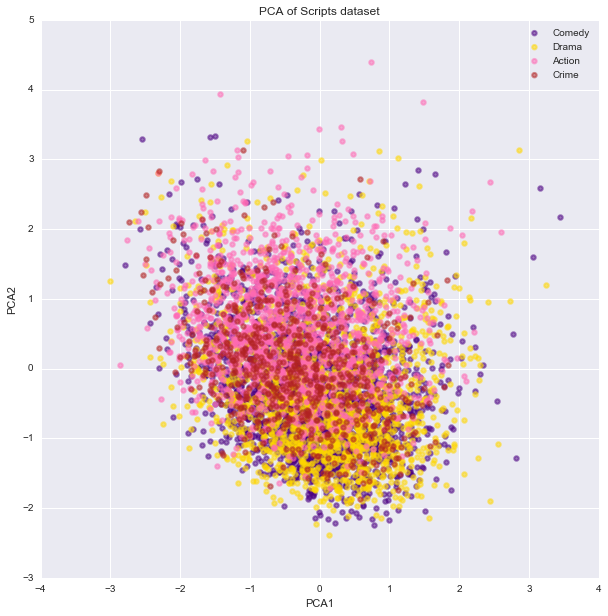

In [87]:
import matplotlib
X       = df[df.columns[:44]]
pca     = PCA(n_components=3,whiten=True)
X_r     = pca.fit_transform(X)
targets = df['Genre1'].values

color_list = []
for name, hex in matplotlib.colors.cnames.iteritems():
    color_list.append([name,hex])

colors = []
for i in range(len(pd.unique(targets))):
    colors.append(color_list[i][0])

n = 4

for color, i, target_name in zip(colors[:n],range(n),target_names.index[:n]):
    plt.scatter(X_r[target_name==targets,0],X_r[target_name==targets,1],color=color,alpha=.5,lw=2,label=target_name)
    
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('PCA of Scripts dataset')
plt.show()

Not much to see here, the X axis is PCA1 explains the maximum variance, PCA2 or y axis explaints the second maximum.
Perform LDA to see if it provides better information of the structure of the data.

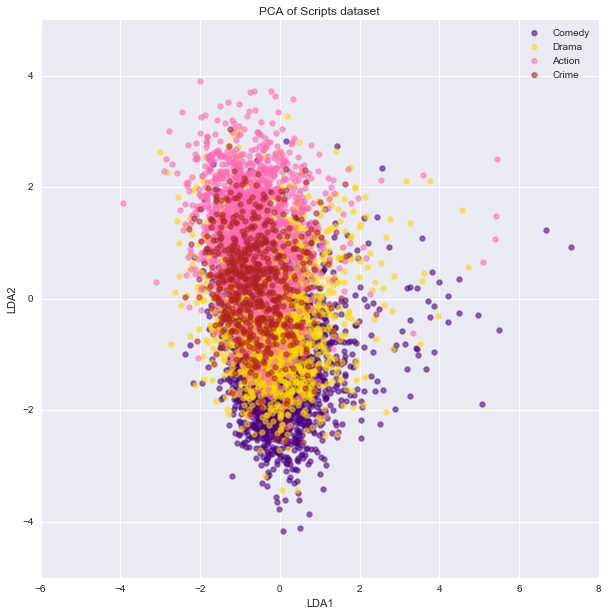

In [88]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

y = []

for i in targets:
    y.append(list(pd.unique(targets)).index(i))
    
lda  = LDA(n_components=3)
X_r2 = lda.fit(X, y).transform(X)

for color, i, target_name in zip(colors[:n],range(n),target_names.index[:n]):
    plt.scatter(X_r2[target_name==targets,0],X_r2[target_name==targets,1],color=color,alpha=.5,lw=2,label=target_name)
    
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.xlabel('LDA1')
plt.ylabel('LDA2')
plt.title('PCA of Scripts dataset')
plt.show()

For the top 4 genres in the dataset, the largest variation is on LDA2, not LDA1. Comedy is at the lower values, followed by Drama then Crime. Action is at the higher values of LDA2.

About the data provided by imdb, it is possible to observe interesting patterns and relationships.

First check if there is a Genre that is a people's favorite, with the highest imdbRating, but first define a function to select only the data we are looking for, **'select'**.

In [92]:
def select(df,feat,values):
    index = []
    for val in df[feat]:
        if val in values:
            index.append(True)
        else:
            index.append(False)
    return df[index]

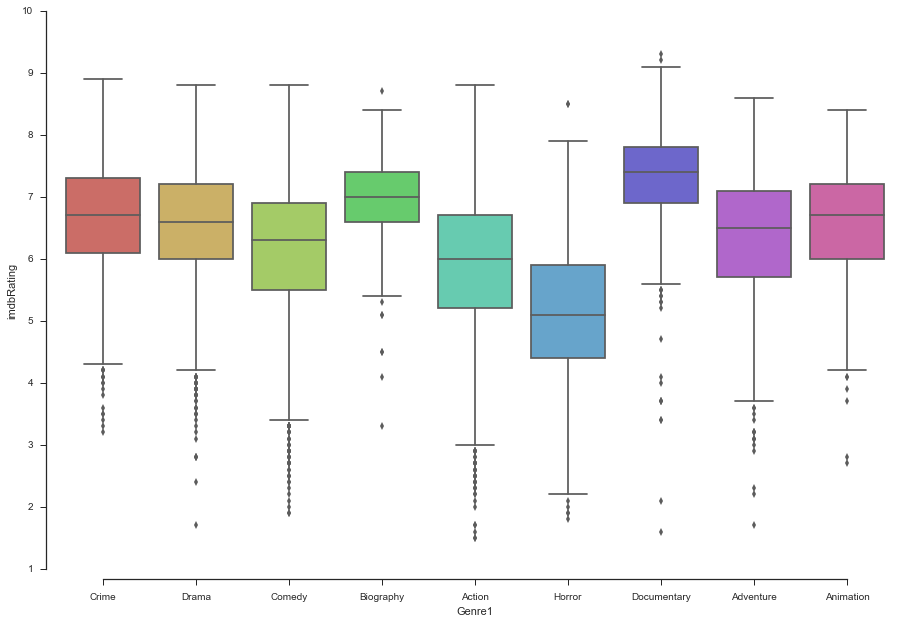

In [114]:
import seaborn as sns
sns.set(style="ticks")

mpl.rc("figure", figsize=(15,10))
sns.boxplot(x="Genre1", y="imdbRating",data=select(df,'Genre1',target_names.index),palette="hls")
sns.despine(offset=10, trim=True)
plt.show()

What about favorite Directors or Actors? Define a list to check them.

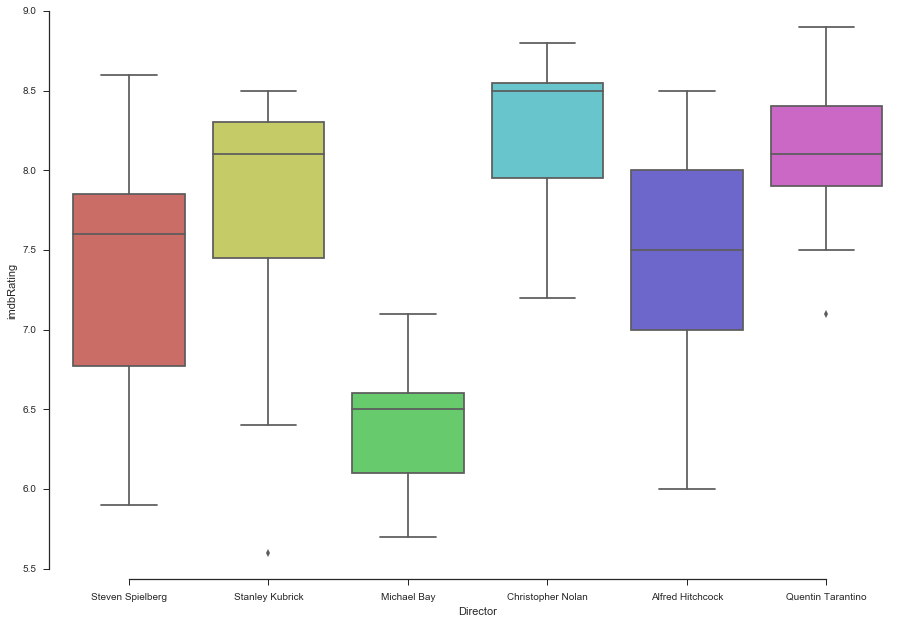

In [120]:
import seaborn as sns
sns.set(style="ticks")

directors = ['Steven Spielberg','Alfred Hitchcock','Quentin Tarantino','Stanley Kubrick','Michael Bay','Christopher Nolan']

mpl.rc("figure", figsize=(15,10))
sns.boxplot(x="Director", y="imdbRating",data=select(df,'Director',directors),palette="hls")
sns.despine(offset=10, trim=True)
plt.show()

From this boxplot can be appreciated that Christopher Nolan and Quentin Tarantino have the highest marks, and Michael Bay the lowest.

Once again for actors.

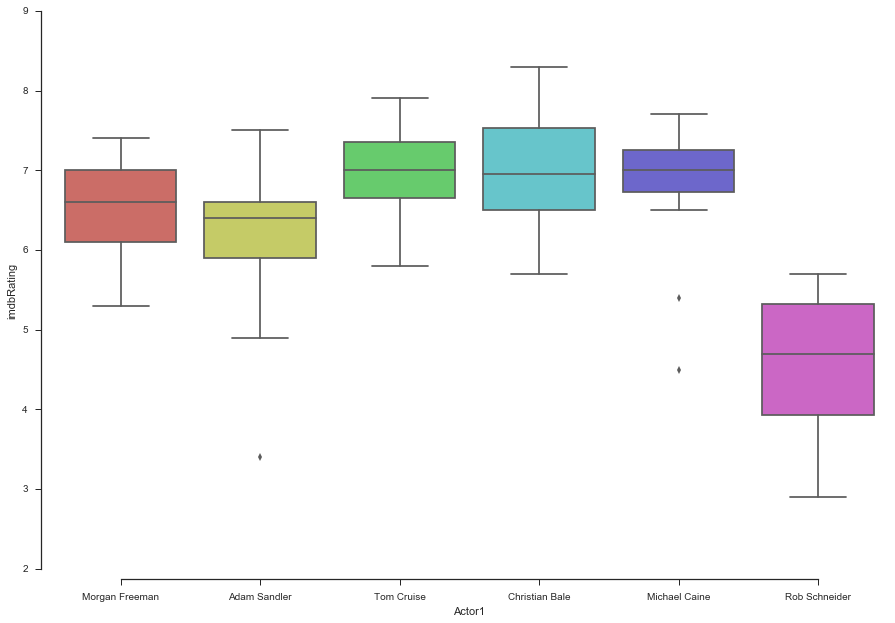

In [119]:
import seaborn as sns
sns.set(style="ticks")

actors = ['Christian Bale','Adam Sandler','Tom Cruise','Michael Caine','Morgan Freeman','Rob Schneider']

mpl.rc("figure", figsize=(15,10))
sns.boxplot(x="Actor1", y="imdbRating",data=select(df,'Actor1',actors),palette="hls")
sns.despine(offset=10, trim=True)
plt.show()

Tom Cruise, Michael Caine and Christian Bale are the favorites whereas Rob Schneider did not fare very well.